# Imports

In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM, Dropout
from keras.layers import LSTM, Input, Bidirectional
from keras.callbacks import ModelCheckpoint
import h5py

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (18,10)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Supporting Functions

In [2]:
def print_distribution(df, labels_column_name):
    n = df.shape[0]
    print("{} labels frequency:".format(labels_column_name))
    print("Value\tCount\tPercent")
    indeces = df[labels_column_name].value_counts().index.tolist()
    counts = df[labels_column_name].value_counts().tolist()
    for val, count in zip(indeces, counts):
        print("{}\t{}\t{}%".format(val, count, (count / float(n)) * 100))
    
def get_max_words(text_arr):
    max_words = 0
    for line in text_arr:
        num_words = len(line.split())
        if num_words > max_words:
            max_words = num_words
    return max_words

# Load data

In [4]:
# Load in the csv data
train_df = pd.read_csv("../../data/headlines/labeled_new/coindesk_news_headlines_labeled_train.csv", index_col=0)
test_df = pd.read_csv("../../data/headlines/labeled_new/coindesk_news_headlines_labeled_dev.csv", index_col=0)

# Data setup

Max number of words per post: 30

Getting x_train, y_train, x_test, and y_test...
3694 train sequences
377 test sequences
----------------------------


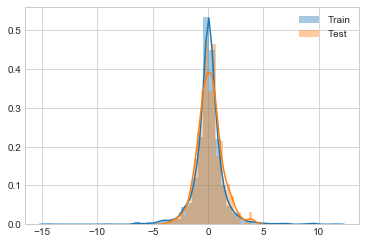

In [7]:
# Determine max post length
max_words_train = get_max_words(train_df.title.values)
max_words_test = get_max_words(test_df.title.values)
max_words = max(max_words_train, max_words_test)
print("Max number of words per post: {}".format(max_words))

# Label and title columns in datasets
LABEL_1HR, LABEL_2HR, LABEL_6HR, LABEL_12HR, LABEL_24HR = \
    '1hr_change', '2hr_change', '6hr_change', '12hr_change', '24hr_change'
TEXT_COL = 'title'

# Split into x_train and y_train
print('\nGetting x_train, y_train, x_test, and y_test...')
(x_train, y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr) = \
    train_df[TEXT_COL].values, train_df[LABEL_1HR], train_df[LABEL_2HR], \
    train_df[LABEL_6HR], train_df[LABEL_12HR], train_df[LABEL_24HR]

m_train = x_train.shape[0]
y_train_1hr = y_train_1hr.values.reshape((m_train, 1))
y_train_2hr = y_train_2hr.values.reshape((m_train, 1))
y_train_6hr = y_train_6hr.values.reshape((m_train, 1))
y_train_12hr = y_train_12hr.values.reshape((m_train, 1))
y_train_24hr = y_train_24hr.values.reshape((m_train, 1))
    
(x_test, y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr) = \
    test_df[TEXT_COL].values, test_df[LABEL_1HR], test_df[LABEL_2HR], \
    test_df[LABEL_6HR], test_df[LABEL_12HR], test_df[LABEL_24HR]

m_test = x_test.shape[0]
y_test_1hr = y_test_1hr.values.reshape((m_test, 1))
y_test_2hr = y_test_2hr.values.reshape((m_test, 1))
y_test_6hr = y_test_6hr.values.reshape((m_test, 1))
y_test_12hr = y_test_12hr.values.reshape((m_test, 1))
y_test_24hr = y_test_24hr.values.reshape((m_test, 1)) 

# Print info about train and test
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print("----------------------------")

# Plot distributions of labels
sns.set_style("whitegrid")
sns.distplot(train_df[LABEL_1HR].values, label='Train')
sns.distplot(test_df[LABEL_1HR].values, label='Test')
plt.legend()

# Model setup (part 1/4)

In [8]:
# Set hyperparameters
max_features = 200000 # Num words in our vocabulary 
maxlen = max_words  # cut texts after this number of words
batch_size = 32  # Mini-batch size
num_epochs = 5 

# Train tokenizer to create a vocabulary of words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

# Vectorize each headline
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Update x_train and x_test to be 'sequences' of data
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)  

Pad sequences (samples x time)
x_train shape: (3694, 30)
x_test shape: (377, 30)


# Model setup (part 2/4)

In [9]:
# Choose embedding layer to use (pre-trained word2vec or custom)
#EMBEDDING_TYPE = "pretrain"
#EMBEDDING_TYPE = "custom1"
EMBEDDING_TYPE = "custom2"

# If using pre-trained word2vec
if EMBEDDING_TYPE == "pretrain":
    EMBEDDING_FILE = "../../data/embeddings/GoogleNews-vectors-negative300.bin"
    EMBEDDING_DIM = 300 
    word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# If using custom word2vec (continuous bag)
elif EMBEDDING_TYPE == "custom1":
    EMBEDDING_FILE = "../word2vec/crypto-word2vec-all-200.bin"
    EMBEDDING_DIM = 200
    word2vec = KeyedVectors.load(EMBEDDING_FILE)

# If using custom word2vec (skipgram)
elif EMBEDDING_TYPE == "custom2":
    EMBEDDING_FILE = "../word2vec/crypto-word2vec-skipgram-all-200.bin"
    EMBEDDING_DIM = 200
    word2vec = KeyedVectors.load(EMBEDDING_FILE)
    
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        
embedding_layer = Embedding(nb_words,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False) 

# Model setup (part 3/4)

In [10]:
# Get the actual embeddings
sequence_input = Input(shape=(maxlen,), dtype='int32')
embeddings = embedding_layer(sequence_input)

# Construct the model
X = Bidirectional(LSTM(128, return_sequences=False))(embeddings)
X = Dense(5)(X)

# Select y labels
y_train = np.concatenate((y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr), axis=1)
y_test = np.concatenate((y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr), axis=1)

# Define the model
model = Model(inputs=sequence_input, outputs=X)

# Compile the model
model.summary()
model.compile(loss='mean_squared_error', 
                    optimizer='adam', 
                    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 200)           1565000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 1,903,181
Trainable params: 338,181
Non-trainable params: 1,565,000
_________________________________________________________________


# Model setup (part 4/4)

In [11]:
# Choose path to save checkpoints
#CHECKPOINT_PATH_SAVE = "checkpoints/pretrained_word2vec/"
#CHECKPOINT_PATH_SAVE = "checkpoints/custom1_word2vec/"
CHECKPOINT_PATH_SAVE = "checkpoints/custom2_word2vec/"

# Setup model checkpoints
checkpoint_5 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-5epochs.hdf5")
checkpoint_10 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-10epochs.hdf5")
checkpoint_15 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-15epochs.hdf5")
checkpoint_20 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-20epochs.hdf5")
checkpoint_25 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-25epochs.hdf5")
checkpoint_30 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-30epochs.hdf5")
checkpoint_35 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-35epochs.hdf5")
checkpoint_40 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-40epochs.hdf5")
checkpoint_45 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-45epochs.hdf5")
checkpoint_50 = ModelCheckpoint(CHECKPOINT_PATH_SAVE + "headlines-50epochs.hdf5")
all_checkpoints = [('5',checkpoint_5), ('10',checkpoint_10), ('15',checkpoint_15), ('20',checkpoint_20), \
                  ('25',checkpoint_25), ('30',checkpoint_30), ('35',checkpoint_35), ('40',checkpoint_40), \
                  ('45',checkpoint_45), ('50',checkpoint_50)]


# Train model for 50 epochs

In [13]:
# Train 50 epochs
for num_checkpoint, checkpoint in all_checkpoints:
    model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(x_test, y_test),
              callbacks=[checkpoint])
    score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    print('Finished training %s/50 epochs' % num_checkpoint)
    print('Test score: %.4f, Test accuracy: %.4f' % (score, acc))

Train on 3694 samples, validate on 377 samples
Epoch 1/5
3694/3694 [==============================] - 4s 1ms/step - loss: 12.4118 - acc: 0.3638 - val_loss: 9.3882 - val_acc: 0.4085
Epoch 2/5
3694/3694 [==============================] - 4s 1ms/step - loss: 12.0046 - acc: 0.3741 - val_loss: 9.6059 - val_acc: 0.3263
Epoch 3/5
3694/3694 [==============================] - 5s 1ms/step - loss: 11.5819 - acc: 0.3733 - val_loss: 10.1744 - val_acc: 0.2971
Epoch 4/5
3694/3694 [==============================] - 4s 1ms/step - loss: 11.0651 - acc: 0.3763 - val_loss: 10.1279 - val_acc: 0.3448
Epoch 5/5
377/377 [==============================] - 0s 318us/step
Finished training 5/50 epochs
Test score: 10.3793, Test accuracy: 0.3554
Train on 3694 samples, validate on 377 samples
Epoch 1/5
3694/3694 [==============================] - 5s 1ms/step - loss: 9.6790 - acc: 0.3977 - val_loss: 11.1952 - val_acc: 0.3289
Epoch 2/5
3694/3694 [==============================] - 4s 1ms/step - loss: 8.9128 - acc: 0.405

Epoch 5/5
377/377 [==============================] - 0s 354us/step
Finished training 50/50 epochs
Test score: 16.1099, Test accuracy: 0.2997


# Load model checkpoints

In [14]:
# Choose which checkpoints to load
#CHECKPOINT_PATH_LOAD = "checkpoints/pretrained_word2vec/"
#CHECKPOINT_PATH_LOAD = "checkpoints/custom1_word2vec/"
CHECKPOINT_PATH_LOAD = "checkpoints/custom2_word2vec/"

# Checkpoint files
checkpoint_files = ["headlines-5epochs.hdf5", "headlines-10epochs.hdf5", "headlines-15epochs.hdf5", "headlines-20epochs.hdf5", \
                   "headlines-25epochs.hdf5", "headlines-30epochs.hdf5", "headlines-35epochs.hdf5", "headlines-40epochs.hdf5", \
                   "headlines-45epochs.hdf5", "headlines-50epochs.hdf5"]

# List to save predictions
all_predictions = []

# Load checkpoints and use to make predictions
for checkpoint_file in checkpoint_files:

    # Construct model
    model_new = Model(inputs=sequence_input, outputs=X)
    model_new.load_weights(CHECKPOINT_PATH_LOAD + checkpoint_file)
    model_new.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    # Make predictions, add to master list
    predictions = model_new.predict(x_test)
    all_predictions.append(predictions)
    
    # Print score and accuracy
    score, acc = model_new.evaluate(x_test, y_test, batch_size=batch_size)
    print('Test score: %.4f, Test accuracy: %.4f' % (score, acc))

377/377 [==============================] - 0s 639us/step
Test score: 10.3793, Test accuracy: 0.3554
377/377 [==============================] - 0s 568us/step
Test score: 13.4377, Test accuracy: 0.3024
377/377 [==============================] - 0s 632us/step
Test score: 15.7685, Test accuracy: 0.2891
377/377 [==============================] - 0s 627us/step
Test score: 15.9116, Test accuracy: 0.3024
377/377 [==============================] - 0s 592us/step
Test score: 14.9105, Test accuracy: 0.3156
377/377 [==============================] - 0s 616us/step
Test score: 15.6314, Test accuracy: 0.2918
377/377 [==============================] - 0s 570us/step
Test score: 16.2669, Test accuracy: 0.2891
377/377 [==============================] - 0s 591us/step
Test score: 16.1708, Test accuracy: 0.2891
377/377 [==============================] - 0s 587us/step
Test score: 16.1119, Test accuracy: 0.3130
377/377 [==============================] - 0s 581us/step
Test score: 16.1099, Test accuracy: 0.2997


# Evaluate the results

### First, organize predictions from each number of epochs trained and print summary

In [23]:
###############################################################
# 1/2: CHANGE if more epochs added
###############################################################

# To iterate through training epochs
epochs = ['05 epochs', '10 epochs', '15 epochs', '20 epochs', \
          '25 epochs', '30 epochs', '35 epochs', '40 epochs', \
          '45 epochs', '50 epochs']

# The number of training epochs chosen for final results
final_chosen_epoch = ['30 epochs']

# Object 1: To zip all dfs together later
all_dfs = (test_df.values, \
           all_predictions[0], all_predictions[1], all_predictions[2], all_predictions[3], \
           all_predictions[4], all_predictions[5], all_predictions[6], all_predictions[7], \
           all_predictions[8], all_predictions[9])


###############################################################
# 2/2: DON'T CHANGE if more epochs added
###############################################################

# Loop through each set and print summary
count = 0
for prediction in all_predictions:
    count += 5
    
    pred_1hr, summary_1hr = prediction[:,0], pd.Series(np.squeeze(prediction[:,0])).describe()
    pred_2hr, summary_2hr = prediction[:,1], pd.Series(np.squeeze(prediction[:,1])).describe()
    pred_6hr, summary_6hr = prediction[:,2], pd.Series(np.squeeze(prediction[:,2])).describe()
    pred_12hr, summary_12hr = prediction[:,3], pd.Series(np.squeeze(prediction[:,3])).describe()
    pred_24hr, summary_24hr = prediction[:,4], pd.Series(np.squeeze(prediction[:,4])).describe()

    print('\nAFTER %d EPOCHS TRAINING' % count)
    print('[+01 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_1hr['mean'], summary_1hr['min'], summary_1hr['25%'], summary_1hr['75%'], summary_1hr['max']))
    print('[+02 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_2hr['mean'], summary_2hr['min'], summary_2hr['25%'], summary_2hr['75%'], summary_2hr['max']))
    print('[+06 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_6hr['mean'], summary_6hr['min'], summary_6hr['25%'], summary_6hr['75%'], summary_6hr['max']))
    print('[+12 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_12hr['mean'], summary_12hr['min'], summary_12hr['25%'], summary_12hr['75%'], summary_12hr['max']))
    print('[+24 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_24hr['mean'], summary_24hr['min'], summary_24hr['25%'], summary_24hr['75%'], summary_24hr['max']))


AFTER 5 EPOCHS TRAINING
[+01 hr]	Mean: 0.0931	Min: -0.5949	25%: -0.1023	75%: 0.2324	Max: 1.4550
[+02 hr]	Mean: 0.0429	Min: -1.1053	25%: -0.2708	75%: 0.2552	Max: 2.3949
[+06 hr]	Mean: 0.1676	Min: -2.2372	25%: -0.3630	75%: 0.5799	Max: 3.8927
[+12 hr]	Mean: 0.4535	Min: -3.0213	25%: -0.3105	75%: 1.0784	Max: 5.8631
[+24 hr]	Mean: 1.0289	Min: -3.4903	25%: -0.2030	75%: 2.1300	Max: 8.0964

AFTER 10 EPOCHS TRAINING
[+01 hr]	Mean: -0.0467	Min: -1.3089	25%: -0.3303	75%: 0.1885	Max: 1.9711
[+02 hr]	Mean: 0.0728	Min: -1.5509	25%: -0.3865	75%: 0.4456	Max: 3.0952
[+06 hr]	Mean: 0.4686	Min: -4.5714	25%: -0.4854	75%: 1.2991	Max: 6.1635
[+12 hr]	Mean: 0.4500	Min: -7.3887	25%: -0.9589	75%: 1.8491	Max: 8.9386
[+24 hr]	Mean: 0.7370	Min: -9.5086	25%: -1.7858	75%: 3.0907	Max: 13.6598

AFTER 15 EPOCHS TRAINING
[+01 hr]	Mean: 0.0417	Min: -1.2914	25%: -0.3122	75%: 0.3720	Max: 2.3257
[+02 hr]	Mean: 0.1046	Min: -2.2956	25%: -0.4930	75%: 0.6179	Max: 4.0217
[+06 hr]	Mean: 0.2839	Min: -5.7525	25%: -0.8330	75%: 1.33

### Then, check prediction performance:
- How many of the largest (positive) ACTUAL price changes did we PREDICT correctly
- How many of the largest (negative) ACTUAL price changes did we PREDICT correctly

### Setup

In [24]:
# Prediction times
prediction_times = ['1hr', '2hr', '6hr', '12hr', '24hr']

# Indices of columns in test df and prediction dfs
actual_columns = {'date' : 0, 'title' : 1, '1hr' : 2, '2hr' : 3, '6hr' : 4, '12hr' : 5, '24hr' : 6}
pred_columns = {'1hr' : 0, '2hr' : 1, '6hr' : 2, '12hr' : 3, '24hr' : 4}

# Set cutoffs to only consider largest (positive) price changes
pos_percent = 0.80 # Means will consider top 20%
pos_1hr = pd.Series(np.squeeze(test_df['1hr_change'])).quantile(pos_percent)
pos_2hr = pd.Series(np.squeeze(test_df['2hr_change'])).quantile(pos_percent)
pos_6hr = pd.Series(np.squeeze(test_df['6hr_change'])).quantile(pos_percent)
pos_12hr = pd.Series(np.squeeze(test_df['12hr_change'])).quantile(pos_percent)
pos_24hr = pd.Series(np.squeeze(test_df['24hr_change'])).quantile(pos_percent)
pos_cutoffs = {'1hr' : pos_1hr, '2hr' : pos_2hr, '6hr' : pos_6hr, '12hr' : pos_12hr, '24hr' : pos_24hr} 

# Set cutoffs to only consider largest (negative) price changes
neg_percent = 0.20 # Means will consider bottom 20%
neg_1hr = pd.Series(np.squeeze(test_df['1hr_change'])).quantile(neg_percent)
neg_2hr = pd.Series(np.squeeze(test_df['2hr_change'])).quantile(neg_percent)
neg_6hr = pd.Series(np.squeeze(test_df['6hr_change'])).quantile(neg_percent)
neg_12hr = pd.Series(np.squeeze(test_df['12hr_change'])).quantile(neg_percent)
neg_24hr = pd.Series(np.squeeze(test_df['24hr_change'])).quantile(neg_percent)
neg_cutoffs = {'1hr' : neg_1hr, '2hr' : neg_2hr, '6hr' : neg_6hr, '12hr' : neg_12hr, '24hr' : neg_24hr} 

# Print
for time in prediction_times:
    print ('[%s] Top cutoff: %.4f, Bottom cutoff: %.4f' % (time, pos_cutoffs[time], neg_cutoffs[time]))

# Initial state of prediction counts
initial_pred_counts = {}
for epoch in epochs:
    initial_pred_counts[epoch] = 0
    
# To keep track of actual changes vs predicted changes (aggregated hourly)
changes = {'1hr':{}, '2hr':{}, '6hr':{}, '12hr':{}, '24hr':{}}
for time in prediction_times:
    for epoch in epochs:
        changes[time][epoch] = []

[1hr] Top cutoff: 0.9681, Bottom cutoff: -0.6646
[2hr] Top cutoff: 1.2951, Bottom cutoff: -1.0128
[6hr] Top cutoff: 2.4297, Bottom cutoff: -1.5298
[12hr] Top cutoff: 3.5341, Bottom cutoff: -1.9239
[24hr] Top cutoff: 5.5177, Bottom cutoff: -2.8084


### Run

In [25]:
###############################################################
# Loop through each prediction time
###############################################################
for time in prediction_times:
       
    # To keep track of (largest positive) counts
    num_actual_above = 0
    num_pred_above, num_pred_positive = initial_pred_counts.copy(), initial_pred_counts.copy()
    per_pred_above, per_pred_positive = initial_pred_counts.copy(), initial_pred_counts.copy() 
    
    # To keep track of (largest negative) counts
    num_actual_below = 0
    num_pred_below, num_pred_negative = initial_pred_counts.copy(), initial_pred_counts.copy()
    per_pred_below, per_pred_negative = initial_pred_counts.copy(), initial_pred_counts.copy() 
    
    # To keep track of aggregated hourly predictions
    total_hours = 1
    total_hours_pos, total_hours_neg = 0, 0
    preds_tally = initial_pred_counts.copy()
    correct_hours_all, per_correct_hours_all = initial_pred_counts.copy(), initial_pred_counts.copy()
    correct_hours_pos, per_correct_hours_pos = initial_pred_counts.copy(), initial_pred_counts.copy()
    correct_hours_neg, per_correct_hours_neg = initial_pred_counts.copy(), initial_pred_counts.copy()
    current_hour = test_df.values[0][actual_columns['date']].split(' ')[1].split(':')[0]
    
    # To keep track of price changes (used to evaluate aggregated predictions)
    prev_price_change = test_df.values[0][actual_columns[time]]
    current_price_change = 0
    
    # To keep track of titles of posts predicted correctly above and below cutoff
    titles_above, titles_below = {}, {}
    for epoch in epochs:
        titles_above[epoch] = []
        titles_below[epoch] = []
        
    #########################################
    # Loop through each row in actual test df and prediction dfs
    #########################################
    for all_items in zip(*all_dfs):
    
        # Separate 
        i, preds = 0, {}
        actual = all_items[i]
        for epoch in epochs:
            i += 1
            preds[epoch] = all_items[i]
           
        # Get current price change
        current_price_change = actual[actual_columns[time]]
        
        #########################################
        # Looking at individual predictions
        #########################################
        
        # Check if actual value >= top cutoff
        if current_price_change >= pos_cutoffs[time]:
            # Increment actual count
            num_actual_above += 1
            # Loop through each set of predictions
            for epoch in epochs:
                # If prediction >= cutoff   
                if preds[epoch][pred_columns[time]] >= pos_cutoffs[time]: 
                    # Count
                    num_pred_above[epoch] += 1
                    # Title
                    titles_above[epoch].append \
                        ((actual[actual_columns['title']], 
                         actual[actual_columns[time]], 
                         preds[epoch][pred_columns[time]]))
                # If prediction at least positive   
                if preds[epoch][pred_columns[time]] >= 0: 
                    num_pred_positive[epoch] += 1
    
        # Check if actual value <= bottom cutoff
        if current_price_change <= neg_cutoffs[time]:
            # Increment actual count
            num_actual_below += 1
            # Loop through each set of predictions
            for epoch in epochs:
                # If prediction >= cutoff   
                if preds[epoch][pred_columns[time]] <= neg_cutoffs[time]: 
                    # Count
                    num_pred_below[epoch] += 1
                    # Title
                    titles_below[epoch].append \
                        ((actual[actual_columns['title']], 
                         actual[actual_columns[time]], 
                         preds[epoch][pred_columns[time]])) 
                # If prediction at least negative   
                if preds[epoch][pred_columns[time]] <= 0: 
                    num_pred_negative[epoch] += 1
    
        #########################################
        # Looking at aggregated predictions
        #########################################
    
        # Isolate hour of current row
        new_hour = actual[actual_columns['date']].split(' ')[1].split(':')[0]
     
        # If moved to new hour
        if not new_hour == current_hour:
            
            # Check prediction tallys vs actual price changes
            for epoch in epochs:
                # All hours
                if np.sign(preds_tally[epoch]) == np.sign(actual[actual_columns[time]]):
                    correct_hours_all[epoch] += 1
                # Hours with largest increases
                if prev_price_change >= pos_cutoffs[time]:
                    if np.sign(preds_tally[epoch]) == np.sign(actual[actual_columns[time]]):
                        correct_hours_pos[epoch] += 1
                # Hours with largest decreases
                if prev_price_change <= neg_cutoffs[time]:
                    if np.sign(preds_tally[epoch]) == np.sign(actual[actual_columns[time]]):
                        correct_hours_neg[epoch] += 1
                
            # Count hours with largest increases and decreases
            if prev_price_change >= pos_cutoffs[time]:
                total_hours_pos += 1
            if prev_price_change <= neg_cutoffs[time]:
                total_hours_neg += 1
                
            # Fill structure to make charts later
            for epoch in epochs:
                changes[time][epoch].append((actual[actual_columns[time]], preds_tally[epoch]))
                
            # Update total hour count, reset tally, change current_hour
            total_hours += 1
            preds_tally = initial_pred_counts.copy()
            current_hour = new_hour
    
        # Update prediction tallys
        for epoch in epochs:
            preds_tally[epoch] += preds[epoch][pred_columns[time]]
            
        # Update saved price change
        prev_price_change = current_price_change
    
    #########################################          
    # Calculate percentage of correct predictions
    #########################################          
    for epoch in epochs:
        
        # Individual predictions
        per_pred_above[epoch] = (num_pred_above[epoch] / num_actual_above) * 100
        per_pred_positive[epoch] = (num_pred_positive[epoch] / num_actual_above) * 100   
        per_pred_below[epoch] = (num_pred_below[epoch] / num_actual_below) * 100
        per_pred_negative[epoch] = (num_pred_negative[epoch] / num_actual_below) * 100   
        
        # Aggregated predictions
        per_correct_hours_all[epoch] = (correct_hours_all[epoch] / total_hours) * 100
        per_correct_hours_pos[epoch] = (correct_hours_pos[epoch] / total_hours_pos) * 100
        per_correct_hours_neg[epoch] = (correct_hours_neg[epoch] / total_hours_neg) * 100

    #########################################          
    # Print results
    #########################################   
    
    # Choose if want to see results for all training epochs, or only final choice
    #to_see = epochs
    to_see = final_chosen_epoch
    
    print ('\n***** PREDICTIONS +%s IN FUTURE *****' % time)
    
    print ('\nTOTAL hours in test set: %d' % (total_hours))           
    for epoch in to_see:
        print ('[%s train] Correctly predicted increases/decreases: %d hours (%.2f%%)' % \
            (epoch, correct_hours_all[epoch], per_correct_hours_all[epoch]))
    
    print ('\nHours in test set with LARGEST %d%% of price INCREASES (>= %.2f%%): %d' % \
        (100-int(pos_percent*100), pos_cutoffs[time], total_hours_pos))           
    for epoch in to_see:
        print ('[%s train] Correctly predicted increases: %d hours (%.2f%%)' % \
            (epoch, correct_hours_pos[epoch], per_correct_hours_pos[epoch]))
  
    print ('\nHours in test set with LARGEST %d%% of price DECREASES (<= %.2f%%): %d' % \
        (100-int(pos_percent*100), neg_cutoffs[time], total_hours_neg))           
    for epoch in to_see:
        print ('[%s train] Correctly predicted decreases: %d hours (%.2f%%)' % \
            (epoch, correct_hours_neg[epoch], per_correct_hours_neg[epoch]))

    '''
    print ('\nNum ACTUAL in top %d%% (change >= %.2f%%): %d' % \
        (100-int(pos_percent*100), pos_cutoffs[time], num_actual_above))           
    for epoch in epochs:
        print ('[%s train] Above cutoff: %d (%.2f%%), Positive: %d (%.2f%%)' % \
            (epoch, num_pred_above[epoch], per_pred_above[epoch], num_pred_positive[epoch], per_pred_positive[epoch]))
        
    print ('\nNum ACTUAL in bottom %d%% (change <= %.2f%%): %d' % \
        (int(neg_percent*100), neg_cutoffs[time], num_actual_below))           
    for epoch in epochs:
        print ('[%s train] Below cutoff: %d (%.2f%%), Negative: %d (%.2f%%)' % \
            (epoch, num_pred_below[epoch], per_pred_below[epoch], num_pred_negative[epoch], per_pred_negative[epoch]))
    
    print ('\nTotal hours in test set: %d' % (total_hours))           
    for epoch in epochs:
        print ('[%s train] Correct aggregated predictions: %d hours (%.2f%%)' % \
            (epoch, correct_hours[epoch], per_correct_hours[epoch]))
                      
    print ('\nPost titles correctly predicted ABOVE cutoff:')     
    for epoch in epochs:
        print ('[%s train]' % epoch)
        for title in titles_above[epoch]:
            print ('\t%s\n\tActual: %.2f, Predicted: %.2f' % (title[0], title[1], title[2]))

    print ('\nPost titles correctly predicted BELOW cutoff:')     
    for epoch in epochs:
        print ('[%s train]' % epoch)
        for title in titles_below[epoch]:
            print ('\t%s\n\tActual: %.2f, Predicted: %.2f' % (title[0], title[1], title[2]))      
   '''
                        


***** PREDICTIONS +1hr IN FUTURE *****

TOTAL hours in test set: 335
[30 epochs train] Correctly predicted increases/decreases: 165 hours (49.25%)

Hours in test set with LARGEST 20% of price INCREASES (>= 0.97%): 68
[30 epochs train] Correctly predicted increases: 29 hours (42.65%)

Hours in test set with LARGEST 20% of price DECREASES (<= -0.66%): 68
[30 epochs train] Correctly predicted decreases: 35 hours (51.47%)

***** PREDICTIONS +2hr IN FUTURE *****

TOTAL hours in test set: 335
[30 epochs train] Correctly predicted increases/decreases: 162 hours (48.36%)

Hours in test set with LARGEST 20% of price INCREASES (>= 1.30%): 69
[30 epochs train] Correctly predicted increases: 29 hours (42.03%)

Hours in test set with LARGEST 20% of price DECREASES (<= -1.01%): 70
[30 epochs train] Correctly predicted decreases: 32 hours (45.71%)

***** PREDICTIONS +6hr IN FUTURE *****

TOTAL hours in test set: 335
[30 epochs train] Correctly predicted increases/decreases: 178 hours (53.13%)

Hours

### Plot the aggregated hourly predictions


***** PREDICTIONS +1hr IN FUTURE *****
[30 epochs train]


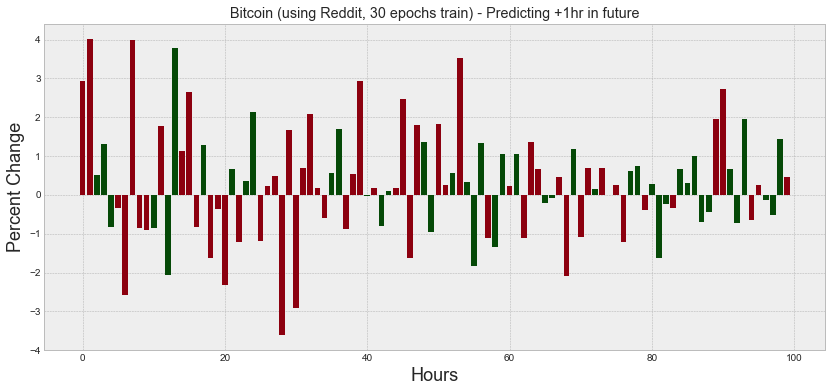


***** PREDICTIONS +2hr IN FUTURE *****
[30 epochs train]


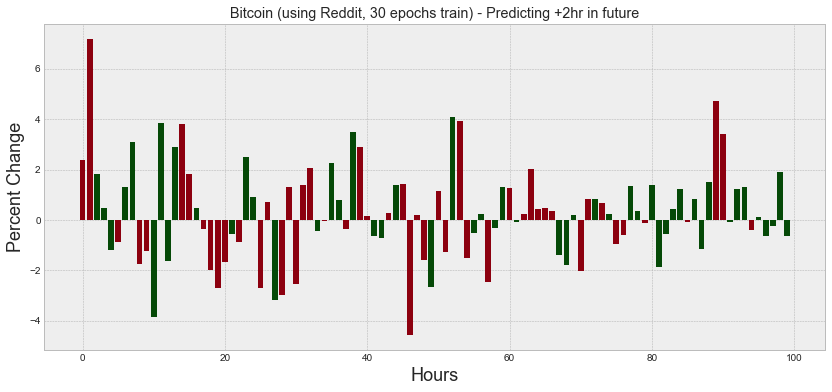


***** PREDICTIONS +6hr IN FUTURE *****
[30 epochs train]


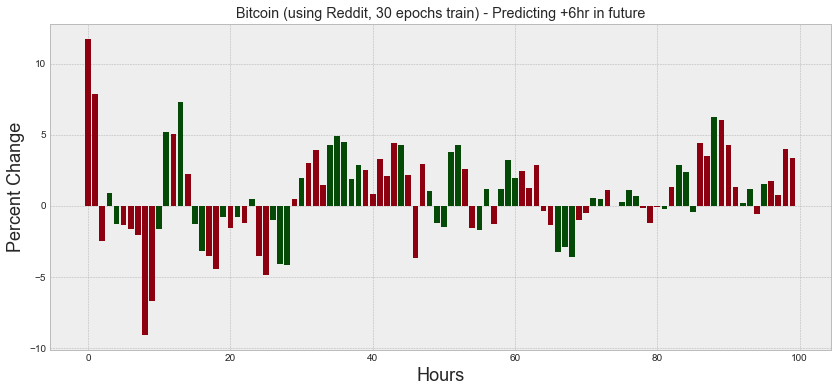


***** PREDICTIONS +12hr IN FUTURE *****
[30 epochs train]


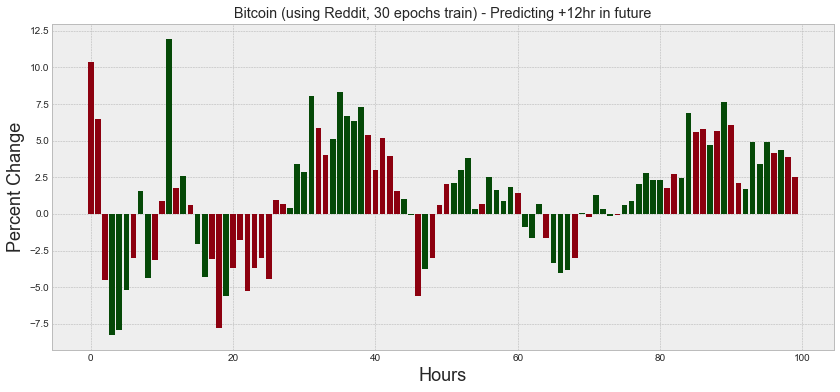


***** PREDICTIONS +24hr IN FUTURE *****
[30 epochs train]


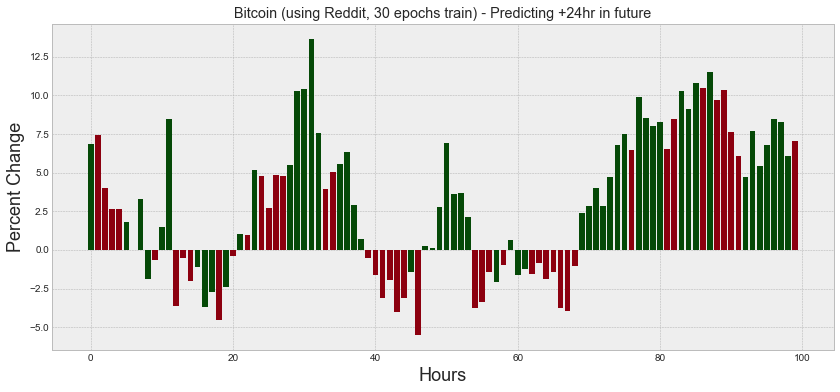

In [26]:
def plot_predicted_changes(changes, title):
        colors = ['xkcd:crimson', 'xkcd:darkgreen']
        pred_colors = []
        percent_changes = []
        for change in changes:
            price_change, pred = change
            if price_change > 0:
                if pred > 0:  # correct
                    percent_changes.append(price_change)
                    pred_colors.append(colors[1])
                else:  # incorrect
                    percent_changes.append(price_change)
                    pred_colors.append(colors[0])
            else:
                if pred < 0:  # correct
                    percent_changes.append(price_change)
                    pred_colors.append(colors[1])
                else:
                    percent_changes.append(price_change)
                    pred_colors.append(colors[0])

        plt.style.use('bmh')
        plt.figure(figsize=(14, 6))
        plt.title('{}'.format(title))
        plt.bar(range(len(percent_changes)), percent_changes, color=pred_colors)
        plt.ylabel('Percent Change', size=18)
        plt.xlabel('Hours', size=18)
        plt.show()

# Loop through each possible chart
for time in prediction_times:
    print ('\n***** PREDICTIONS +%s IN FUTURE *****' % time)
    
    # Choose if want to see results for all training epochs, or only final choice
    #to_see = epochs
    to_see = final_chosen_epoch
    
    # Choose starting and stoping hours
    start_hour = 0
    stop_hour = 100 # needs to be less than 670
    
    for epoch in to_see:
        print ('[%s train]' % epoch)
        change = changes[time][epoch][start_hour:stop_hour] 
        title = 'Bitcoin (using Reddit, %s train) - Predicting +%s in future' % (epoch, time)
        plot_predicted_changes(change, title)
        